In [1]:
import pandas as pd
import janitor
import numpy as np
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import save_mpl_fig
from utilities.utils import pandas_to_tex
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.5, 
              style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# df = (get_fulldata(**{'nrows':5_000})
usecols = ['account_no', 'caste', 'name_of_father', '6', '7', '8']
df = (get_fulldata(**{'usecols':usecols, 'engine':'pyarrow', 'use_nullable_dtypes':True})
# df = (get_fulldata(**{'nrows':5_000})
      .rename_columns(new_column_names={"6": "acres", "7": "decimals", "8": "hectare"})
      .assign(tt_area_acre=lambda df: df["acres"]+df["decimals"]/100)
      .query("tt_area_acre>0")
      .assign(last_name_of_father=lambda df: df["name_of_father"].str.split().str[0])
      .merge(
          # Read in castecodes
          (pd
           .read_stata("../data/caste_codes/caste_code_landrecords.dta")
           .drop_duplicates(subset=['caste_landrecords'])
          ),
          how="left",
          left_on="caste",
          right_on="caste_landrecords",
          validate="m:1",
      )
      .case_when(
          lambda df: df.muslim==1, "Muslim",
          lambda df: df.muslim==0, "Non-Muslim",
          default=np.nan,
          column_name="religion",
      )
      .dropna(subset=["religion"])
     )

print(df.shape)
df

(25330932, 20)


,account_no,caste,name_of_father,acres,decimals,hectare,tt_area_acre,last_name_of_father,caste_landrecords,count,caste_translit,caste_standard,caste_name,caste_code,caste_category,bihar_district_code,muslim,dup_caste_name,m_cc,religion
0,1801010001000002,ब्रहामण,लगनदेव पाठक,0.0,66.0,0.0,0.66,लगनदेव,ब्रहामण,20260.0,brahāmaṇa,brahman,brahmin,uc-0/001,uc,,0.0,0.0,Matched (3),Non-Muslim
1,1801010001000002,ब्रहामण,लगनदेव पाठक,0.0,8.0,0.0,0.08,लगनदेव,ब्रहामण,20260.0,brahāmaṇa,brahman,brahmin,uc-0/001,uc,,0.0,0.0,Matched (3),Non-Muslim
2,1801010001000002,ब्रहामण,लगनदेव पाठक,0.0,6.0,0.0,0.06,लगनदेव,ब्रहामण,20260.0,brahāmaṇa,brahman,brahmin,uc-0/001,uc,,0.0,0.0,Matched (3),Non-Muslim
3,1801010001000002,ब्रहामण,लगनदेव पाठक,0.0,3.0,0.0,0.03,लगनदेव,ब्रहामण,20260.0,brahāmaṇa,brahman,brahmin,uc-0/001,uc,,0.0,0.0,Matched (3),Non-Muslim
4,1801010001000002,ब्रहामण,लगनदेव पाठक,0.0,36.0,0.0,0.36,लगनदेव,ब्रहामण,20260.0,brahāmaṇa,brahman,brahmin,uc-0/001,uc,,0.0,0.0,Matched (3),Non-Muslim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38654375,1402151675000018,कोइरी,जौजे द्वारिका भगत,0.0,9.0,0.0,0.09,जौजे,कोइरी,658042.0,koirī,koeri,koeri,bc-2/004,bc2,,0.0,0.0,Matched (3),Non-Muslim
38654376,1402151675000018,कोइरी,जौजे द्वारिका भगत,0.0,11.0,0.0,0.11,जौजे,कोइरी,658042.0,koirī,koeri,koeri,bc-2/004,bc2,,0.0,0.0,Matched (3),Non-Muslim
38654377,1402151675000018,कोइरी,जौजे द्वारिका भगत,0.0,6.0,0.0,0.06,जौजे,कोइरी,658042.0,koirī,koeri,koeri,bc-2/004,bc2,,0.0,0.0,Matched (3),Non-Muslim
38654378,1402151675000018,कोइरी,जौजे द्वारिका भगत,0.0,11.0,0.0,0.11,जौजे,कोइरी,658042.0,koirī,koeri,koeri,bc-2/004,bc2,,0.0,0.0,Matched (3),Non-Muslim


In [3]:
100*len(df.query("muslim==0"))/len(df.dropna(subset=["muslim"]))

93.56009877567868

In [4]:
100*len(df.query("muslim==1"))/len(df.dropna(subset=["muslim"]))

6.439901224321316

In [5]:
100*len(df.query("muslim==9"))/len(df.dropna(subset=["muslim"]))

0.0

In [6]:
table = df.groupby('muslim').agg({'muslim': 'count'})
table = table / table.sum() * 100
table

,muslim
muslim,
0.0,93.560099
1.0,6.439901


## Summary numbers

In [7]:
# Land plots are owned by muslim
n_land_muslim = len(df.query("religion=='Muslim'"))
perc_land_muslim = 100*n_land_muslim/len(df)

print(f"{n_land_muslim:,.0f} ({perc_land_muslim:.1f}%) land plots are owned by muslim")

1,631,287 (6.4%) land plots are owned by muslim


In [8]:
df_num_plots = (df
                .groupby(["account_no", 'religion'])
                .size()
                .reset_index()
                .rename_column(0, 'nplots')
               )
df_num_plots.head(3)

,account_no,religion,nplots
0,101010273000001,Non-Muslim,2
1,101010273000002,Non-Muslim,8
2,101010273000003,Non-Muslim,1


In [9]:
n_accounts_muslim = len(df_num_plots.query("religion=='Muslim'"))
perc_accounts_muslim = 100*n_accounts_muslim/len(df_num_plots)

print(f"{n_accounts_muslim:,.0f} ({perc_accounts_muslim:.1f}%) accounts are under muslim")

522,917 (7.7%) accounts are under muslim


## Number of plots per account, by religion

In [10]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_nplot_perc_nonmuslim = (df_num_plots
                      .query("religion=='Non-Muslim'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_nonmuslim')
                      .astype({"nplots_nonmuslim":int})
                     )
tab_nplot_perc_muslim = (df_num_plots
                      .query("religion=='Muslim'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_muslim')
                      .astype({"nplots_muslim":int})
                     )
tab_nplot_perc = (tab_nplot_perc_muslim
                  .merge(tab_nplot_perc_nonmuslim, 
                         on="Percentile", 
                         how="left", 
                         validate="1:1"
                        )
                  .assign(
                      nplots_muslim=lambda df: df.nplots_muslim.map('{:,.0f}'.format),
                      nplots_nonmuslim=lambda df: df.nplots_nonmuslim.map('{:,.0f}'.format)
                  )
                 )
pandas_to_tex(tab_nplot_perc, "../tables/percentiles_landplots_per_accountholder_religion", float_format="%.2f")
tab_nplot_perc

,Percentile,nplots_muslim,nplots_nonmuslim
0,0.00,1,1
1,0.10,1,1
2,0.20,1,1
3,0.30,1,1
4,0.40,1,1
5,0.50,1,1
6,0.60,2,2
7,0.70,2,3
8,0.80,4,4
9,0.90,7,9


In [11]:
LINESTYLES = ["-", "--"]
DISPLOT_OPTS = dict(
    aspect=1.5,
    height=6,
    hue="religion",
    legend=False,
    palette="cividis",
    linewidth=2.5,
)
HISTDENSITY_OPTS = dict(
    hue="religion",
    legend=False,
    palette="cividis",
)

LEGEND_OPTS = {"title":"", 
               "loc":'best', 
               "labels":["Muslim", "Non-Muslim"], 
               "frameon":False, 
               "fontsize":24, 
               "handletextpad":0.3
              }
cutoff = 0.95  # percentile to trim at 

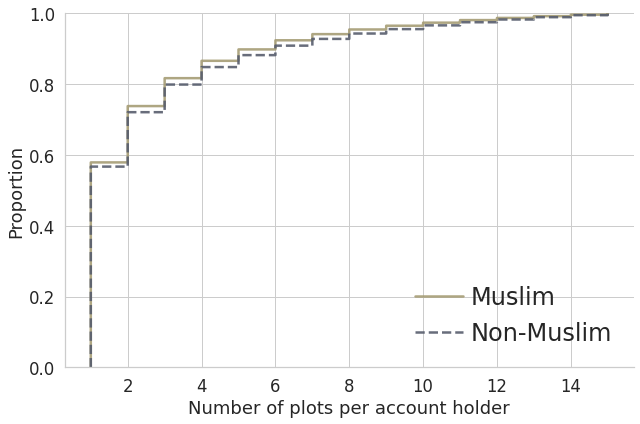

In [12]:
# Empirical CDF of #plots owned per account (fold cell)
g = sns.displot(
    x="nplots", 
    data=df_num_plots.query(f"nplots<={df_num_plots.nplots.quantile(cutoff)}"), 
    alpha=0.9,
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Number of plots per account holder")
save_mpl_fig('../figures/number_plots_per_accountholder_ecdf_religion')

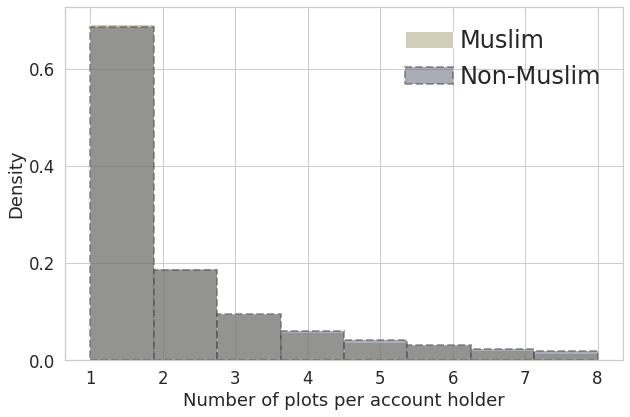

In [13]:
# Histogram of #plots owned per account (fold cell)
_, ax = plt.subplots(figsize=(10,6.5))
_n = 8
sns.histplot(data=df_num_plots.query(f"nplots<={_n}"),
             x='nplots', 
             bins=_n, 
             stat='density', 
             common_norm=False,
             **HISTDENSITY_OPTS,
             alpha=.5,
             ax=ax,
            )
plt.xlabel("Number of plots per account holder")
plt.yticks([0, 0.2,.4,.6])

bars = ax.containers[1].get_children()  # second set is for female
for bar in bars:
    bar.set_linestyle('--')
    bar.set_linewidth(2)
    bar.set_edgecolor("0.3")
    bar.set_alpha(.5)
plt.legend(**LEGEND_OPTS)    
save_mpl_fig('../figures/number_plots_per_accountholder_histogram_religion')

## Land area per account, by religion

In [14]:
df_landarea = (df
               .groupby(["account_no", 'religion'])["tt_area_acre"]
               .sum()
               .reset_index()
              )
df_landarea.head(3)

,account_no,religion,tt_area_acre
0,101010273000001,Non-Muslim,0.585
1,101010273000002,Non-Muslim,1.545
2,101010273000003,Non-Muslim,0.080


In [15]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_area_perc_nonmuslim = (df_landarea
                      .query("religion=='Non-Muslim'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_nonmuslim')
                     )
tab_area_perc_muslim = (df_landarea
                      .query("religion=='Muslim'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_muslim')
                     )
tab_area_perc = (tab_area_perc_muslim
                 .merge(tab_area_perc_nonmuslim, 
                        on="Percentile", 
                        how="left", 
                        validate="1:1"
                       )
                  .assign(
                      area_muslim=lambda df: df.area_muslim.map('{:,.2f}'.format),
                      area_nonmuslim=lambda df: df.area_nonmuslim.map('{:,.2f}'.format)
                  )                 
                )
pandas_to_tex(tab_area_perc, "../tables/percentiles_landarea_per_accountholder_religion", float_format="%.2f")
tab_area_perc

,Percentile,area_muslim,area_nonmuslim
0,0.00,0.00,0.00
1,0.10,0.04,0.04
2,0.20,0.08,0.08
3,0.30,0.13,0.14
4,0.40,0.20,0.22
5,0.50,0.29,0.34
6,0.60,0.43,0.51
7,0.70,0.64,0.80
8,0.80,1.03,1.32
9,0.90,2.02,2.68


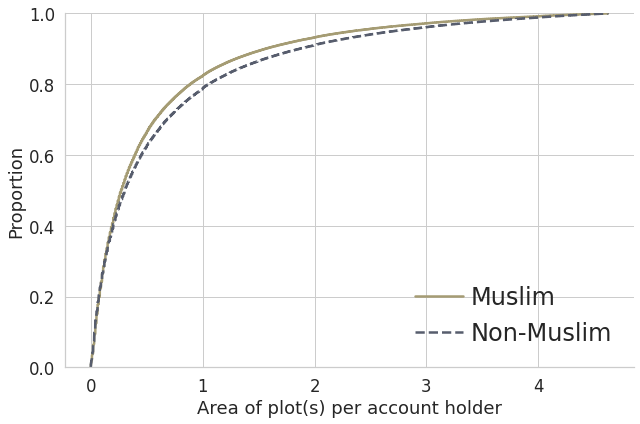

In [16]:
# Empirical CDF of land plot area owned per account (fold cell)
g = sns.displot(
    x="tt_area_acre", 
    data=df_landarea.query(f"tt_area_acre<={df_landarea.tt_area_acre.quantile(cutoff)}"), 
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Area of plot(s) per account holder")
save_mpl_fig('../figures/plot_area_per_accountholder_ecdf_religion')

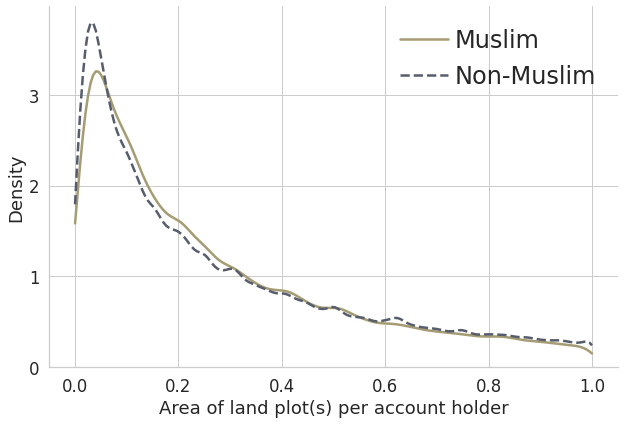

In [17]:
# Histogram of land plot area owned per account (fold cell)
_area = 1
g = sns.displot(data=df_landarea.query(f"tt_area_acre<={_area}"), 
                x="tt_area_acre", 
                kind='kde',
                common_norm=False,
                **DISPLOT_OPTS,
                cut=0
                )
g.set_xlabels("Area of land plot(s) per account holder")
plt.locator_params(axis="y", nbins=5)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
save_mpl_fig('../figures/plot_area_per_accountholder_kde_religion')